# Assignment 2 - MiniPacman

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import pyglet

In [2]:
import json
from mini_pacman import PacmanGame

with open('test_params.json', 'r') as file:
    read_params = json.load(file)
game_params = read_params['params']
env = PacmanGame(**game_params)

env.render()

In [3]:
from tabulate import tabulate
print(tabulate([[1,'Down-Left'], \
                [2,'Down'], \
                [3,'Down-Right'], \
                [4,'Left'], \
                [5,'No Move'], \
                [6,'Right'], \
                [7,'Up-Left'], \
                [8,'Up'], \
                [9,'Up-Right']], \
               headers = ['Action Code','Move'], \
              tablefmt='orgtbl'))

|   Action Code | Move       |
|---------------+------------|
|             1 | Down-Left  |
|             2 | Down       |
|             3 | Down-Right |
|             4 | Left       |
|             5 | No Move    |
|             6 | Right      |
|             7 | Up-Left    |
|             8 | Up         |
|             9 | Up-Right   |


In [4]:
obs = env.make_action(5)
env.render()

In [5]:
obs

{'reward': 0,
 'total_score': 0,
 'end_game': True,
 'player': (3, 4),
 'monsters': [(3, 4), (4, 4)],
 'diamonds': [(2, 3), (5, 3), (5, 4)],
 'walls': [(1, 2),
  (2, 1),
  (2, 2),
  (3, 3),
  (4, 1),
  (4, 2),
  (4, 5),
  (4, 6),
  (6, 3),
  (6, 6)],
 'possible_actions': [1, 2, 5, 6, 7, 8, 9]}

In [6]:
env.get_obs()

{'reward': 1,
 'total_score': 1,
 'end_game': False,
 'player': (4, 0),
 'monsters': [(1, 4), (6, 3)],
 'diamonds': [(0, 7), (1, 5), (4, 5)],
 'walls': [(1, 3),
  (2, 0),
  (2, 1),
  (2, 5),
  (3, 6),
  (4, 1),
  (4, 4),
  (7, 2),
  (7, 4),
  (7, 6)],
 'possible_actions': [2, 3, 5, 8, 9]}

In [6]:
# Render random-action game
obs = env.reset()
while not obs['end_game']:
    action = random.choice(obs['possible_actions'])
    obs = env.make_action(action)
    env.render()
    time.sleep(0.5)

In [7]:
game_scores=[]
for one_game in range(100):
    obs = env.reset()
    while not obs['end_game']:    
        action = random.choice(obs['possible_actions'])
        obs = env.make_action(action)
    game_scores.append(obs['total_score'])
print('Mean: ',np.mean(game_scores),'\nMedian: ',np.median(game_scores))

Mean:  47.39 
Median:  8.0


In [9]:
#env.close()

# DQN Mini-Pacman

In [8]:
import random
import gc
import time
import numpy as np

from keras.models import Sequential, clone_model
from keras.layers import Dense, InputLayer
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, TensorBoard
import keras.backend as K

Using TensorFlow backend.


In [9]:
def create_dqn_model(input_shape, nb_actions):
    model = Sequential()
    model.add(Dense(units=8, input_shape=input_shape, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return model

In [10]:
action_to_dxdy = {1: (1, -1),
                  2: (1, 0),
                  3: (1, 1),
                  4: (0, -1),
                  5: (0, 0),
                  6: (0, 1),
                  7: (-1, -1),
                  8: (-1, 0),
                  9: (-1, 1)}

In [11]:
def get_state(obs):
    v = []
    x,y = obs['player']
    v.append(x)
    v.append(y)
    for x, y in obs['monsters']:
        v.append(x)
        v.append(y)
    for x, y in obs['diamonds']:
        v.append(x)
        v.append(y)
    for x, y in obs['walls']:
        v.append(x)
        v.append(y)
    return v

In [12]:
class QLearn:
    def __init__(self, gamma=0.95, alpha=0.05):
        from collections import defaultdict
        self.gamma = gamma
        self.alpha = alpha
        self.qmap = defaultdict(int)

    def iteration(self, old_state, old_action, reward, new_state, new_possible_actions):
        # Produce iteration step (update Q-Value estimates)
        old_stateaction = tuple(old_state) + (old_action,)
        max_q = max([self.qmap[tuple(new_state) + (a,)] for a in new_possible_actions])
        self.qmap[old_stateaction] = (1-self.alpha)*self.qmap[old_stateaction] + self.alpha*(reward+self.gamma*max_q)
        return

    def best_action(self, state, possible_actions):
        # Get the action with highest Q-Value estimate for specific state
        a, q = max([(a, self.qmap[tuple(state) + (a,)]) for a in possible_actions], key=lambda x: x[1])
        return a

In [13]:
input_shape = (len(get_state(env.reset())),)
nb_actions = len(action_to_dxdy)
print('input_shape: ',input_shape)
print('nb_actions: ',nb_actions)

online_network = create_dqn_model(input_shape, nb_actions)
online_network.compile(optimizer=Adam(), loss='mse')
target_network = clone_model(online_network)
target_network.set_weights(online_network.get_weights())

input_shape:  (32,)
nb_actions:  9
Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 81        
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________
None


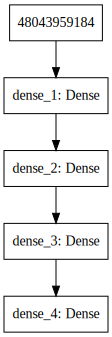

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
print(online_network.summary())

SVG(model_to_dot(online_network).create(prog='dot', format='svg'))

In [15]:
from keras.utils import plot_model
plot_model(online_network, to_file='online_network.png',show_shapes=True,show_layer_names=True)

In [16]:
from collections import deque
replay_memory_maxlen = 1_000_000
replay_memory = deque([], maxlen=replay_memory_maxlen)

In [17]:
def epsilon_greedy(q_values, epsilon, n_outputs):
    if random.random() < epsilon:
        return random.randrange(n_outputs)  # random action
    else:
        return np.argmax(q_values)  # q-optimal action

In [18]:
n_steps = 100_000 # number of times 
warmup = 1_000 # first iterations after random initiation before training starts
training_interval = 4 # number of steps after which dqn is retrained
copy_steps = 2_000 # number of steps after which weights of 
                   # online network copied into target network
gamma = 0.99 # discount rate
batch_size = 64 # size of batch from replay memory 
eps_max = 1.0 # parameters of decaying sequence of eps
eps_min = 0.05
eps_decay_steps = 50_000

In [21]:
step = 0
iteration = 0
done = True 

obs = env.reset()
print('Observtion: ',[get_state(obs)])
q_values = online_network.predict(np.array([get_state(obs)]))
print('Q-values',q_values)

Observtion:  [[7, 1, 0, 1, 3, 2, 4, 2, 4, 4, 5, 4, 0, 3, 1, 5, 1, 7, 2, 3, 2, 4, 2, 5, 3, 3, 3, 4, 3, 5, 7, 5]]
Q-values [[-0.4955921  -0.7388129   0.2947756  -0.14595076  0.03176532 -0.05919297
  -0.46131817  0.14764033 -0.21158531]]


In [22]:
epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
action = epsilon_greedy(q_values, epsilon, nb_actions)
print('Epsilon: ',epsilon, ', Action: ', action)

Epsilon:  1.0 , Action:  8


In [23]:
next_obs= env.make_action(action + 1)
reward = next_obs['reward']
done = next_obs['end_game']
replay_memory.append((obs, action, reward, next_obs, done))
obs = next_obs

In [24]:
print('Record in replay memory')
print('Previous state: ',replay_memory[0][0])
print('Action: ',replay_memory[0][1])
print('Reward: ',replay_memory[0][2])
print('Next state: ',replay_memory[0][3])
print('Game end: ',replay_memory[0][4])

Record in replay memory
Previous state:  {'reward': 0, 'total_score': 0, 'end_game': False, 'player': (7, 1), 'monsters': [(0, 1), (3, 2)], 'diamonds': [(4, 2), (4, 4), (5, 4)], 'walls': [(0, 3), (1, 5), (1, 7), (2, 3), (2, 4), (2, 5), (3, 3), (3, 4), (3, 5), (7, 5)], 'possible_actions': [4, 5, 6, 7, 8, 9]}
Action:  8
Reward:  1
Next state:  {'reward': 1, 'total_score': 1, 'end_game': False, 'player': (6, 2), 'monsters': [(1, 0), (3, 1)], 'diamonds': [(4, 2), (4, 4), (5, 4)], 'walls': [(0, 3), (1, 5), (1, 7), (2, 3), (2, 4), (2, 5), (3, 3), (3, 4), (3, 5), (7, 5)], 'possible_actions': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
Game end:  False


In [25]:
step = 0
iteration = 0
done = True
warmup = 64

for iter in range(warmup):
    if done:
        obs = env.reset()
    q_values = online_network.predict(np.array([get_state(obs)]))
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    action = epsilon_greedy(q_values, epsilon, nb_actions)
    next_obs= env.make_action(action + 1)
    reward = next_obs['reward']
    done = next_obs['end_game']
    replay_memory.append((obs, action, reward, next_obs, done))
    obs = next_obs
len(replay_memory)    

65

In [26]:
minibatch = random.sample(replay_memory, batch_size)
replay_state = np.array([get_state(x[0]) for x in minibatch])
replay_action = np.array([x[1]for x in minibatch])
replay_rewards = np.array([x[2] for x in minibatch])
replay_next_state = np.array([get_state(x[3]) for x in minibatch])
replay_done = np.array([x[4] for x in minibatch], dtype=int)
replay_action

array([5, 6, 6, 5, 1, 5, 6, 7, 0, 8, 5, 2, 5, 4, 2, 5, 2, 0, 1, 0, 4, 3,
       8, 8, 4, 5, 8, 6, 4, 2, 4, 4, 3, 5, 5, 4, 8, 4, 0, 2, 8, 3, 1, 6,
       5, 2, 2, 3, 1, 6, 3, 8, 8, 4, 8, 6, 8, 4, 7, 3, 8, 1, 4, 6])

In [27]:
target_predict = target_network.predict(replay_next_state)
print('Target prediction shape: ', target_predict.shape)
print('Example of predicted values: ',target_predict[3])

Target prediction shape:  (64, 9)
Example of predicted values:  [-0.50585145 -0.7315772   0.6279112   0.14420241  0.27508873 -0.10717981
 -0.8325552   0.4355373  -0.33174753]


In [28]:
print('Shape of the max: ',np.amax(target_predict,axis=1).shape)

Shape of the max:  (64,)


In [29]:
target_for_action = replay_rewards + (1-replay_done) * gamma * \
                                    np.amax(target_predict, axis=1)
target = online_network.predict(replay_state)  # targets coincide with predictions ...
print('Target predicted by online network')
print(target[:5])
target[np.arange(batch_size), replay_action] = target_for_action
print('Update with values predicted by target network')
print(target[:5])
print('Replay actions and target_for_action')
for i in range(5):
    print(replay_action[i],target_for_action[i])

Target predicted by online network
[[-1.51706398e-01 -1.34126276e-01  9.56300646e-04  4.97048050e-02
  -6.77769855e-02  7.68779032e-03 -1.00923419e-01  2.98611950e-02
  -1.08146146e-01]
 [-7.47463703e-02 -2.50267506e-01  1.51786476e-01 -1.18295059e-01
   1.84495836e-01 -1.66529357e-01  3.88406664e-02 -3.34581882e-02
  -3.41103524e-02]
 [-6.99378252e-01 -6.27969384e-01  7.53068179e-03  2.33250722e-01
  -3.03930551e-01  3.36765051e-02 -4.72657740e-01  1.30811572e-01
  -4.89663899e-01]
 [-6.13682389e-01 -7.85284460e-01  5.18227339e-01  2.80459315e-01
   1.49262309e-01  2.63910592e-02 -6.95352614e-01  4.10202861e-01
  -4.04189676e-01]
 [-2.75650382e-01 -7.92139113e-01  7.96026587e-01 -3.94928813e-01
   4.89898324e-01 -2.29447991e-01 -9.62268353e-01  3.40225458e-01
   8.03752840e-02]]
Update with values predicted by target network
[[-1.51706398e-01 -1.34126276e-01  9.56300646e-04  4.97048050e-02
  -6.77769855e-02  0.00000000e+00 -1.00923419e-01  2.98611950e-02
  -1.08146146e-01]
 [-7.474637

In [37]:
from keras.models import load_model
dqn_model = load_model('saved_dqn_model.h5')

In [38]:
def test_dqn_strategy(obs):
    q_values = online_network.predict(np.array([get_state(obs)]))[0]
    action = epsilon_greedy(q_values, 0.05, nb_actions)
    return action+1

In [39]:
from mini_pacman import test
test(strategy=test_dqn_strategy, log_file='test_pacman_log.json')

Your average score is 22.68, median is 4.0, saved log to 'test_pacman_log.json'. Do not forget to upload it for submission!


4.0

In [40]:
from mini_pacman import test
from mini_pacman import random_strategy
test(strategy=random_strategy, log_file='test_pacman_log.json')

Your average score is 38.618, median is 5.0, saved log to 'test_pacman_log.json'. Do not forget to upload it for submission!


5.0

In [41]:
from mini_pacman import test
from mini_pacman import naive_strategy
test(strategy=naive_strategy, log_file='test_pacman_log.json')

Your average score is 107.476, median is 100.0, saved log to 'test_pacman_log.json'. Do not forget to upload it for submission!


100.0